In [2]:
from src import PINNViga
from src import Carga
from src import Apoio
import matplotlib.pyplot as plt
import numpy as np
import json
import pandas as pd
import time
import torch
import torch.nn as nn
from itertools import product
from tqdm import tqdm

VIGA BIAPOIADA

In [3]:
## SEÇÃO DA VIGA

b = 0.2
h = 0.4
E = 30e9
I = b * (h ** 3) / 12
EI = E * I

In [4]:
# VIGA BIAPOIADA
# CRIANDO OS APOIOS

L = 4

## CRIANDO OS APOIOS

apoio_esq = Apoio.Apoio([1, 1, 1], [0, 0])
apoio_meio = Apoio.Apoio([0, 1, 0], [L / 2, 0])
apoio_dir = Apoio.Apoio([0, 1, 0], [L, 0])
apoio_dir2 = Apoio.Apoio([0, 1, 0], [3 * L / 2, 0])

lista_apoios = [apoio_esq, apoio_meio, apoio_dir]
lista_apoios = [apoio_esq, apoio_meio, apoio_dir, apoio_dir2]
# lista_apoios = [apoio_esq, apoio_dir]

## CRIANDO CARGAS

q = -10e3

# q2 = Carga.CargaDistribuida([0, q], [0, 0], [L, 0])
q2 = Carga.CargaDistribuida([0, q], [0, 0], [3 * L / 2, 0])

cargas = [q2]

In [17]:
## LOOP DE TREINAMENTO

biapoiada = PINNViga.PINNViga(lista_apoios, cargas, E, I)
biapoiada.run_model(num_epochs=3500)
biapoiada.run_sol_analitica(tam = 30)

Epoch 0, Loss: 4.625992298126, PDE Loss: 4.578782081604, BC Loss: 0.029201762751, INT Loss: 0.018008338287
Epoch 350, Loss: 0.020601838827, PDE Loss: 0.006630064920, BC Loss: 0.009214399382, INT Loss: 0.004757373594
Epoch 700, Loss: 0.000759990129, PDE Loss: 0.000453637622, BC Loss: 0.000232632185, INT Loss: 0.000073720294
Epoch 1050, Loss: 0.000255865540, PDE Loss: 0.000228100515, BC Loss: 0.000023245404, INT Loss: 0.000004519618
Epoch 1400, Loss: 0.000156921626, PDE Loss: 0.000149430358, BC Loss: 0.000006228054, INT Loss: 0.000001263215
Epoch 1750, Loss: 0.000108916829, PDE Loss: 0.000106392647, BC Loss: 0.000001946273, INT Loss: 0.000000577907
Epoch 2100, Loss: 0.000096611417, PDE Loss: 0.000095194271, BC Loss: 0.000001102315, INT Loss: 0.000000314834
Epoch 2450, Loss: 0.000051471070, PDE Loss: 0.000051003884, BC Loss: 0.000000370004, INT Loss: 0.000000097182
Epoch 2800, Loss: 0.000036372465, PDE Loss: 0.000036122772, BC Loss: 0.000000197438, INT Loss: 0.000000052255
Epoch 3150, Los

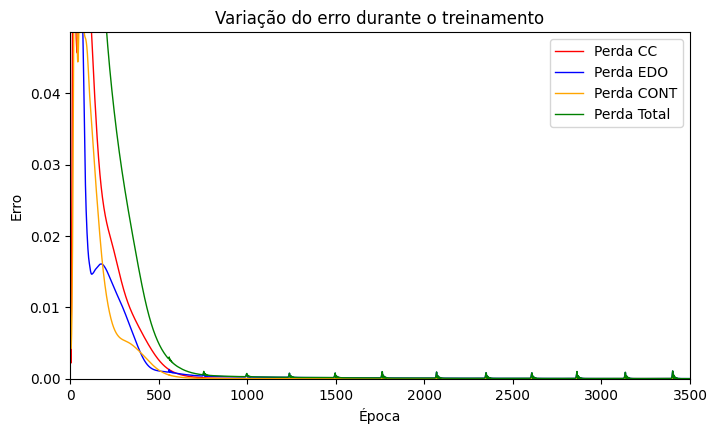

In [18]:
biapoiada.plot_errors(100)

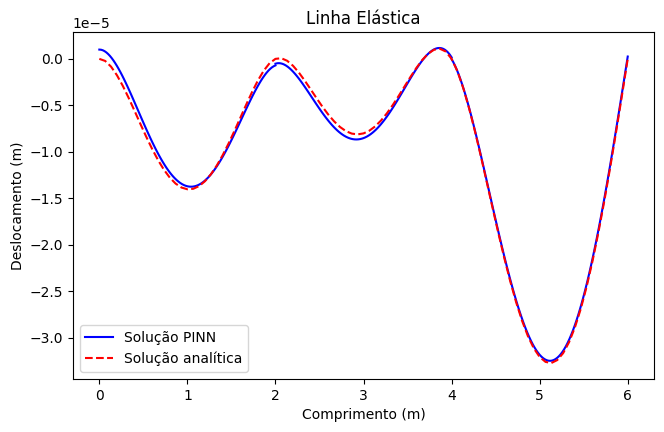

In [19]:
biapoiada.plot_deslocamento()

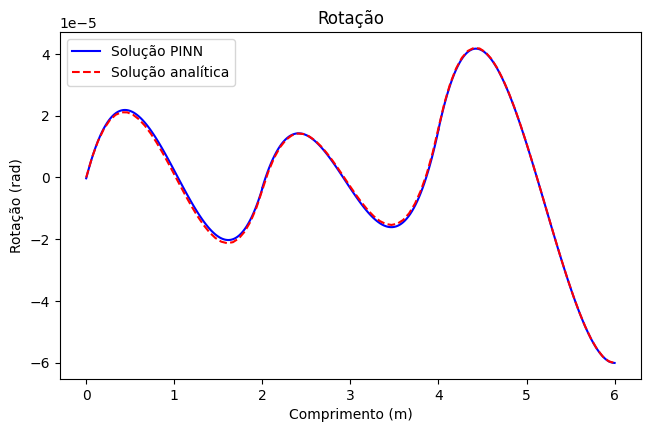

In [20]:
biapoiada.plot_rotacao()

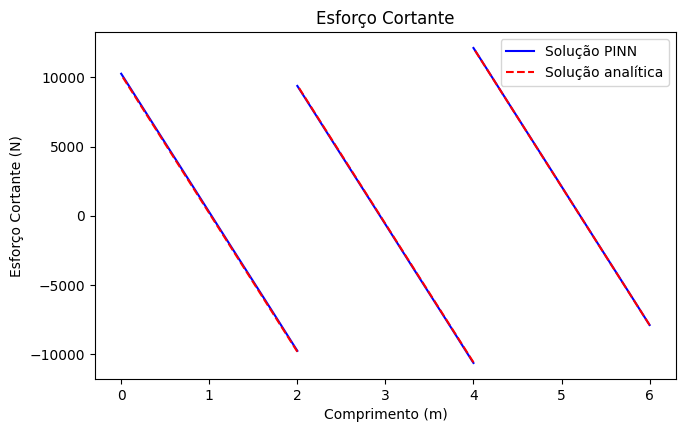

In [21]:
biapoiada.plot_cortante()

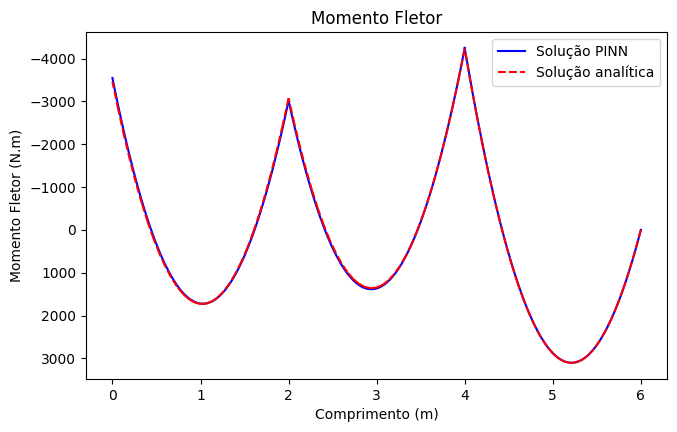

In [22]:
biapoiada.plot_momento()

In [ ]:
## LOOP DE TREINAMENTO

biapoiada_lbfgs = PINNViga.PINNViga(lista_apoios, cargas, E, I, otimizador="lbfgs")
biapoiada_lbfgs.run_model(num_epochs=30, tol = 1e-7)
biapoiada_lbfgs.run_sol_analitica(tam = 20)

Epoch 0, Loss: 0.083753786981, PDE Loss: 0.033363822848, BC Loss: 0.021410521120, INT Loss: 0.028979444876
Epoch 3, Loss: 0.001695392421, PDE Loss: 0.000883970177, BC Loss: 0.000563847250, INT Loss: 0.000247574935
Epoch 6, Loss: 0.000080306490, PDE Loss: 0.000076550336, BC Loss: 0.000002495130, INT Loss: 0.000001261029
Epoch 9, Loss: 0.000021266296, PDE Loss: 0.000019724303, BC Loss: 0.000001365144, INT Loss: 0.000000176849
Epoch 12, Loss: 0.000004386992, PDE Loss: 0.000004374908, BC Loss: 0.000000005117, INT Loss: 0.000000006967
Epoch 15, Loss: 0.000001624741, PDE Loss: 0.000001617509, BC Loss: 0.000000002788, INT Loss: 0.000000004444
Epoch 18, Loss: 0.000000505594, PDE Loss: 0.000000488750, BC Loss: 0.000000015213, INT Loss: 0.000000001631
Epoch 21, Loss: 0.000000401817, PDE Loss: 0.000000401519, BC Loss: 0.000000000140, INT Loss: 0.000000000158
Epoch 24, Loss: 0.000000401817, PDE Loss: 0.000000401519, BC Loss: 0.000000000140, INT Loss: 0.000000000158
Epoch 27, Loss: 0.000000401817, 

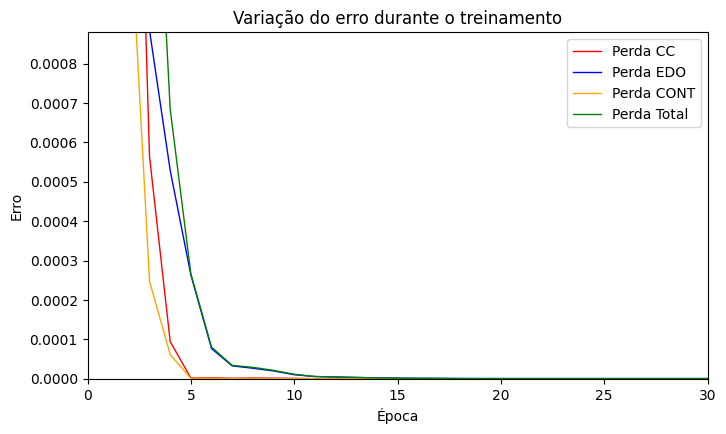

In [12]:
biapoiada_lbfgs.plot_errors(100)

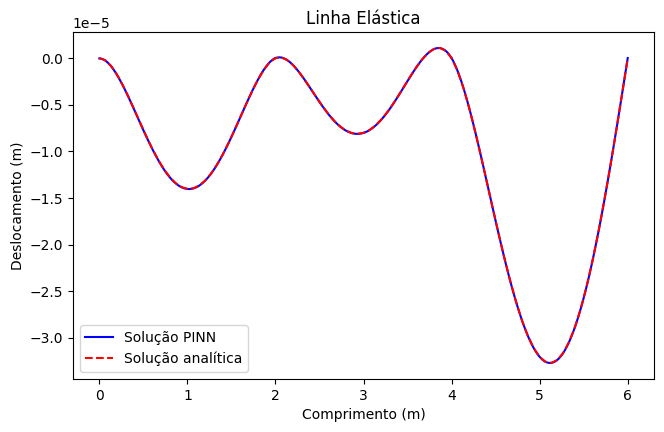

In [13]:
biapoiada_lbfgs.plot_deslocamento()

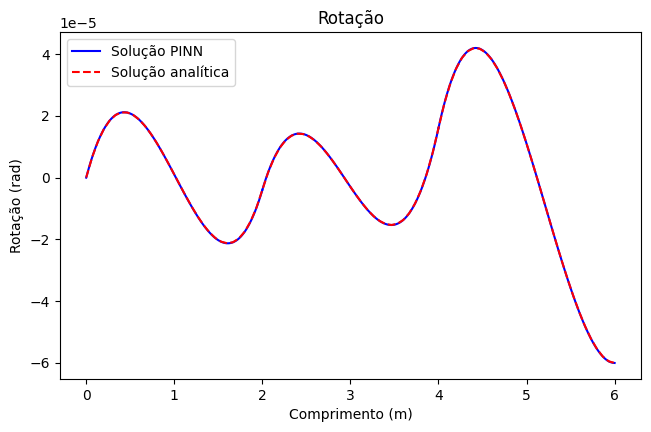

In [14]:
biapoiada_lbfgs.plot_rotacao()

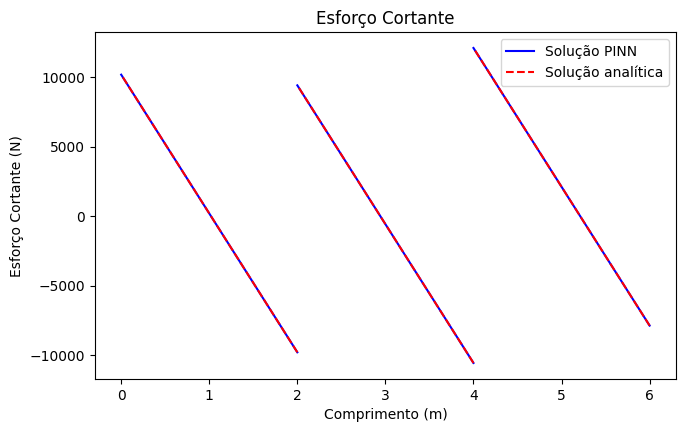

In [15]:
biapoiada_lbfgs.plot_cortante()

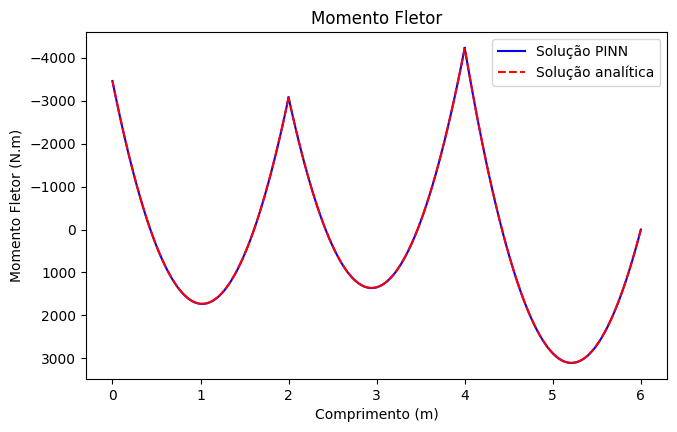

In [16]:
biapoiada_lbfgs.plot_momento()